<a href="https://colab.research.google.com/github/angel870326/XLNet_Text_Classification/blob/main/xlnet_multi_class_chinese_train_product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 2022.05.14 Ssu-Yun Wang<br/>
[Github @angel870326](https://github.com/angel870326)

# **XLNet Multi-class Text Classification for Chinese and English**
Available for both multi-label and single-label classification.

## **Contents**
1. Dataset
   *   Raw dataset
   *   Clean dataset
   *   Convert 'product' to dummy variables
   *   Get small sample of train and test to try (optional)
<br/>
2. Preprocessing<br/>
   (1) XLNetTokenizer & Sentence embedding<br/>
   (2) Tokenize input texts into ids<br/>
   (3) Create attention masks<br/>
   (4) Add input ids and attention masks to the dataframe<br/>
3. Train, Valid Split<br/>
4. Create Dataloaders (torch tensors)<br/>
5. Training<br/>
   (1) Functions<br/>
   (2) Train model from scratch<br/>
   (3) Train model from previous checkpoint<br/>
6. Get Predictions<br/>
   (1) Testing<br/>
   (2) For single-label classification<br/>
   (3) Save the predicting results<br/>


** Modified from  https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df*

In [ ]:
!pip install transformers
# !pip install sentencepiece # for English

     |████████████████████████████████| 4.2 MB 4.9 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 6.6 MB 42.3 MB/s 
     |████████████████████████████████| 596 kB 44.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [ ]:
import os
import math
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# GPU
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


## **1. Dataset**


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Raw dataset

In [ ]:
train_raw = pd.read_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/資料檔/category_train.csv')
test_raw = pd.read_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/資料檔/category_test.csv')

In [ ]:
train_raw.head()

,id,name,clean_name,product
0,46952,虎牌啤酒485ml四入,虎牌啤酒四入,啤酒
1,66349,虎牌jai-g55r電子鍋,虎牌jai-g55r電子鍋,電子鍋
2,76618,妝點甜心遮瑕蜜cannelle,妝點甜心遮瑕蜜cannelle,遮瑕蜜
3,85910,【鮮一杯】衣索匹亞西達摩濾掛咖啡(10gx10入),鮮一杯衣索匹亞西達摩濾掛咖啡x,濾掛/耳掛咖啡
4,84545,irocksk75m淡雅粉白色背光機械式鍵盤-紅軸,irocksk淡雅粉白色背光機械式鍵盤-紅軸,鍵盤


In [ ]:
test_raw.head()

,id,name,clean_name,product
0,44444,媚點防曬保濕礦物粉底液(亮膚色)oc-c1,媚點防曬保濕礦物粉底液亮膚色oc-c,粉底液
1,822,代收代付-理膚寶水水感保濕清新化妝水200ml(原廠公司貨)專品藥局【2006256】,理膚寶水水感保濕清新化妝水原廠公司貨專品藥局,化妝水
2,28998,妮維雅男士全效控油潔面泥150g,妮維雅男士全效控油潔面泥,洗面乳
3,90670,韓國isleaf香氛順盈護髮油-茉氣十足100ml,韓國isleaf香氛順盈護髮油-茉氣十足,護髮乳
4,15903,美琪抗菌沐浴乳(杏桃花與蜂蜜q10)680ml,美琪抗菌沐浴乳杏桃花與蜂蜜q10,沐浴乳


### Clean dataset

In [ ]:
train_data = {'id': train_raw['id'],
              'name': train_raw['clean_name'],
              'product': train_raw['product']}
train_clean = pd.DataFrame(train_data)
train_clean

,id,name,product
0,46952,虎牌啤酒四入,啤酒
1,66349,虎牌jai-g55r電子鍋,電子鍋
2,76618,妝點甜心遮瑕蜜cannelle,遮瑕蜜
3,85910,鮮一杯衣索匹亞西達摩濾掛咖啡x,濾掛/耳掛咖啡
4,84545,irocksk淡雅粉白色背光機械式鍵盤-紅軸,鍵盤
...,...,...,...
73524,6266,桂格高鐵高鈣奶粉7倍膠原蛋白罐,成人奶粉
73525,54887,weet-bix澳洲全穀麥片麥香高鈣組,麥片穀類
73526,76821,oatly原味燕麥奶,燕麥奶
73527,861,bioneo百妮玻尿酸保濕化妝水凝露,化妝水


In [ ]:
test_data = {'id': test_raw['id'],
             'name': test_raw['clean_name'],
             'product': test_raw['product']}
test = pd.DataFrame(test_data)
test

,id,name,product
0,44444,媚點防曬保濕礦物粉底液亮膚色oc-c,粉底液
1,822,理膚寶水水感保濕清新化妝水原廠公司貨專品藥局,化妝水
2,28998,妮維雅男士全效控油潔面泥,洗面乳
3,90670,韓國isleaf香氛順盈護髮油-茉氣十足,護髮乳
4,15903,美琪抗菌沐浴乳杏桃花與蜂蜜q10,沐浴乳
...,...,...,...
18378,30670,曼秀雷敦acnes抗痘洗面乳,洗面乳
18379,73028,春風捲筒式廚房紙巾6捲,廚房紙巾
18380,70725,clarins克蘭詩黃金雙激萃-超級精華-國際版,精華液
18381,61125,hongyew鴻宇防蹣抗菌美國棉兒童睡袋可機洗被胎台灣製多款花色,睡袋


### Convert 'product' to dummy variables

In [ ]:
train = train_clean[['id', 'name']]
products = pd.get_dummies(train_clean['product'])
train = pd.concat([train, products], axis=1)
train

,id,name,bb霜,cc霜,dd霜,rtd調酒,中式香腸,乳酸菌,人工淚液,保久乳,...,電磁爐,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類
0,46952,虎牌啤酒四入,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66349,虎牌jai-g55r電子鍋,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,76618,妝點甜心遮瑕蜜cannelle,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,85910,鮮一杯衣索匹亞西達摩濾掛咖啡x,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,84545,irocksk淡雅粉白色背光機械式鍵盤-紅軸,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73524,6266,桂格高鐵高鈣奶粉7倍膠原蛋白罐,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73525,54887,weet-bix澳洲全穀麥片麥香高鈣組,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
73526,76821,oatly原味燕麥奶,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73527,861,bioneo百妮玻尿酸保濕化妝水凝露,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get small sample of train and test to try (optional)

In [ ]:
# train = train.sample(n=1000)
# test = test.sample(n=100)

## **2. Preprocessing**


---



### (1) XLNetTokenizer & Sentence embedding

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [ ]:
# XLNetTokenizer (for English)
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

# AutoTokenizer (for Chinese)
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-xlnet-base")

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/671 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/675k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/202 [00:00<?, ?B/s]

In [ ]:
# Texts for classification
train_text_list = train['name'].values
test_text_list = test['name'].values

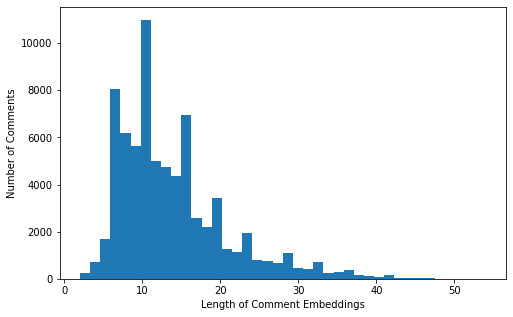

In [ ]:
# train
plot_sentence_embeddings_length(train_text_list, tokenizer)

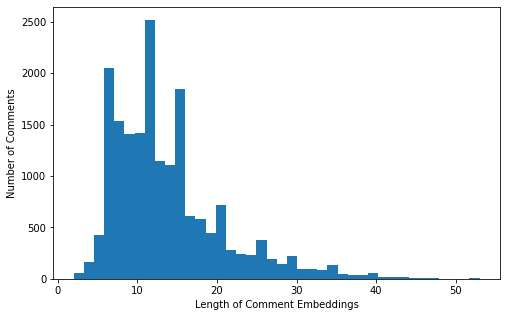

In [ ]:
# test
plot_sentence_embeddings_length(test_text_list, tokenizer)

### (2) Tokenize input texts into ids
*   Append the appropriate special characters to the end of the text to denote end of sentence.
*   Truncate or pad the appropriate sequence length.



In [ ]:
# 這裡可能要再改
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    # tokenize the text, then truncate sequence to the desired length minus 2 for the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

In [ ]:
# Create input id tokens (train)
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=50) # number of embeddings can be modified
train_input_ids

array([[   19,  1387,   977, ...,     0,     0,     0],
       [   19,  1387,   977, ...,     0,     0,     0],
       [   19, 12937,   433, ...,     0,     0,     0],
       ...,
       [   19,  1142,  2667, ...,     0,     0,     0],
       [ 8439,  4563, 13432, ...,     0,     0,     0],
       [   19,  1627,  5164, ...,     0,     0,     0]])

In [ ]:
# Create input id tokens (test)
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=50) # number of embeddings can be modified
test_input_ids

array([[   19, 18677,   433, ...,     0,     0,     0],
       [   19,   643, 22356, ...,     0,     0,     0],
       [   19,  2572,   635, ...,     0,     0,     0],
       ...,
       [ 9169, 16759,  9758, ...,     0,     0,     0],
       [   19,  1141,  4898, ...,     0,     0,     0],
       [   19,   150,  2405, ...,     0,     0,     0]])

### (3) Create attention masks
*   Tell model whether attention should be applied to the input id tokens.
*   Do not want to perform attention on padding tokens.

In [ ]:
def create_attn_masks(input_ids):
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# Create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

### (4) Add input ids and attention masks to the dataframe

In [ ]:
# train
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks
# test
test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [ ]:
train.head()

,id,name,bb霜,cc霜,dd霜,rtd調酒,中式香腸,乳酸菌,人工淚液,保久乳,...,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類,features,masks
0,46952,虎牌啤酒四入,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 1387, 977, 9234, 176, 212, 4, 3, 0, 0, 0,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
1,66349,虎牌jai-g55r電子鍋,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 1387, 977, 9384, 1110, 13, 1232, 1726, 11...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,76618,妝點甜心遮瑕蜜cannelle,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 12937, 433, 4741, 256, 8351, 23898, 6027,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,85910,鮮一杯衣索匹亞西達摩濾掛咖啡x,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 5925, 59, 2252, 1675, 688, 4437, 429, 88,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,84545,irocksk淡雅粉白色背光機械式鍵盤-紅軸,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 4218, 9868, 10401, 2938, 717, 2314, 2401,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
test.head()

,id,name,product,features,masks
0,44444,媚點防曬保濕礦物粉底液亮膚色oc-c,粉底液,"[19, 18677, 433, 1131, 23069, 666, 9505, 18989...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,822,理膚寶水水感保濕清新化妝水原廠公司貨專品藥局,化妝水,"[19, 643, 22356, 899, 111, 111, 963, 666, 9505...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,28998,妮維雅男士全效控油潔面泥,洗面乳,"[19, 2572, 635, 717, 1012, 345, 213, 3775, 256...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,90670,韓國isleaf香氛順盈護髮油-茉氣十足,護髮乳,"[19, 1448, 1988, 1407, 13884, 874, 26726, 1662...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,15903,美琪抗菌沐浴乳杏桃花與蜂蜜q10,沐浴乳,"[19, 214, 4691, 1952, 2440, 16459, 8963, 3250,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


## **3. Train, Valid Split**


---



In [ ]:
# train valid split
train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [ ]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

# products column names
label_cols = products.columns.values.tolist()
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

## **4. Create Dataloaders (torch tensors)**
---

Convert all of the input ids and attention masks into torch tensors, the required datatype for the model.


In [ ]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [ ]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. 
# With an iterator, the entire dataset does not need to be loaded into memory.
train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

## **5. Training**


---



### (1) Functions

Train the model and save the model with the lowest validation loss.

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i
    """
    Training
    """
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      # scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)
    print("Train loss: {}".format(epoch_train_loss))

    """
    Validation
    """
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()
    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    # Update tracking variables
    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)
    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set

Save the model to the path directory provided.

In [ ]:
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return

Load the model from the path directory provided.

In [ ]:
def load_model(save_path):
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

### (2) Train model from scratch

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    # self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased') # for English
    self.xlnet = AutoModel.from_pretrained("hfl/chinese-xlnet-base")
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at hfl/chinese-xlnet-base were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Need GPU
# Modify output path

num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/output/xlnet_product_train.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.0006460749913651678
Valid loss: 0.00010087330091029228


Epoch:  33%|███▎      | 1/3 [11:57<23:55, 717.72s/it]

Saving model at epoch 0 with validation loss of 0.00010087330091029228


Train loss: 6.837956222176025e-05
Valid loss: 4.687752193791347e-05


Epoch:  67%|██████▋   | 2/3 [23:59<11:59, 719.84s/it]

Saving model at epoch 1 with validation loss of 4.687752193791347e-05


Train loss: 3.95774511989349e-05
Valid loss: 4.2440463022524775e-05


Epoch: 100%|██████████| 3/3 [36:00<00:00, 720.22s/it]

Saving model at epoch 2 with validation loss of 4.2440463022524775e-05




Text(0.5, 1.0, 'Loss vs Number of Epochs')

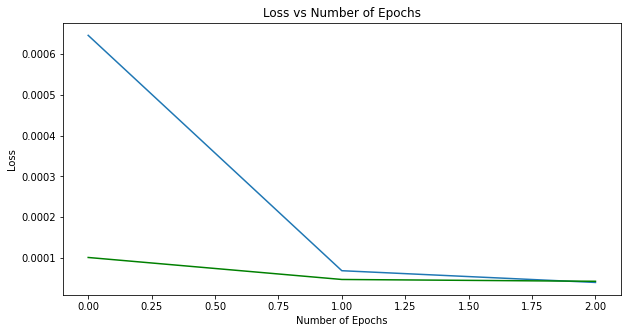

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

### (3) Train model from previous checkpoint

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/output/xlnet_product_train.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

Some weights of the model checkpoint at hfl/chinese-xlnet-base were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
num_epochs=3
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              train_loss_set=train_loss_hist,\
                                              valid_loss_set=valid_loss_hist,\
                                              lowest_eval_loss=lowest_eval_loss,\
                                              start_epoch=start_epoch,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 3.3648390051954325e-05


Epoch:  33%|███▎      | 1/3 [12:00<24:01, 720.90s/it]

Valid loss: 4.4097667957927645e-05


Train loss: 1.897028920842613e-05
Valid loss: 3.831214487075507e-05


Epoch:  67%|██████▋   | 2/3 [24:02<12:01, 721.41s/it]

Saving model at epoch 3 with validation loss of 3.831214487075507e-05


Train loss: 1.5635316996084904e-05
Valid loss: 3.552546060040177e-05


Epoch: 100%|██████████| 3/3 [36:03<00:00, 721.32s/it]

Saving model at epoch 4 with validation loss of 3.552546060040177e-05




Text(0.5, 1.0, 'Loss vs Number of Epochs')

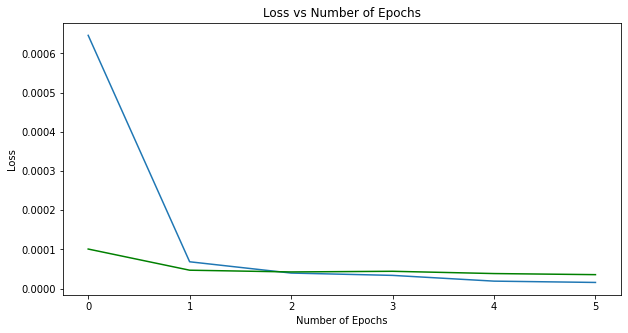

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## **6. Get Predictions**


---



### (1) Testing

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[5.61576528e-08, 3.40664513e-07, 8.12090875e-08, ...,
        3.63011594e-07, 3.85476415e-05, 7.45575335e-07],
       [6.76433842e-07, 3.02221622e-07, 2.37066729e-07, ...,
        5.56262876e-07, 4.74386219e-09, 2.68055510e-06],
       [2.68583648e-07, 2.08210427e-08, 7.30869587e-08, ...,
        5.84959530e-08, 1.32856224e-08, 2.19019356e-07],
       ...,
       [9.84058829e-07, 6.15572446e-08, 5.35310463e-08, ...,
        2.88262232e-08, 2.00384036e-07, 2.89708595e-07],
       [1.61211318e-07, 5.10301241e-08, 1.53830527e-07, ...,
        1.79360001e-07, 1.78019484e-08, 8.90515651e-07],
       [6.23784473e-08, 4.36766889e-08, 1.56984843e-08, ...,
        3.62328088e-08, 1.66616860e-06, 2.39456290e-06]])

In [ ]:
for i in label_cols:
  test[i] = pred_probs[:,label_cols.index(i)]

test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,id,name,product,features,masks,bb霜,cc霜,dd霜,rtd調酒,中式香腸,...,電磁爐,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類
0,44444,媚點防曬保濕礦物粉底液亮膚色oc-c,粉底液,"[19, 18677, 433, 1131, 23069, 666, 9505, 18989...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.615765e-08,3.406645e-07,8.120909e-08,9.451681e-08,1.823221e-06,...,6.947834e-09,3.315878e-08,7.029092e-08,9.233788e-08,3.784845e-07,7.135359e-05,3.861552e-07,3.630116e-07,3.854764e-05,7.455753e-07
1,822,理膚寶水水感保濕清新化妝水原廠公司貨專品藥局,化妝水,"[19, 643, 22356, 899, 111, 111, 963, 666, 9505...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.764338e-07,3.022216e-07,2.370667e-07,2.286781e-05,3.402259e-07,...,6.568044e-07,9.674093e-07,9.008917e-06,2.702137e-08,5.489419e-07,6.033755e-07,7.726392e-07,5.562629e-07,4.743862e-09,2.680555e-06
2,28998,妮維雅男士全效控油潔面泥,洗面乳,"[19, 2572, 635, 717, 1012, 345, 213, 3775, 256...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.685836e-07,2.082104e-08,7.308696e-08,8.225767e-07,4.845813e-08,...,1.883081e-08,1.153386e-07,9.162176e-08,9.073870e-07,3.556088e-08,4.904047e-08,3.753185e-08,5.849595e-08,1.328562e-08,2.190194e-07
3,90670,韓國isleaf香氛順盈護髮油-茉氣十足,護髮乳,"[19, 1448, 1988, 1407, 13884, 874, 26726, 1662...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.351916e-07,5.613654e-09,4.469093e-07,1.404611e-06,1.445865e-06,...,1.010856e-07,1.594375e-08,5.079595e-07,3.134442e-07,5.019692e-08,5.440589e-07,1.008657e-06,3.420477e-07,1.212310e-07,9.378061e-07
4,15903,美琪抗菌沐浴乳杏桃花與蜂蜜q10,沐浴乳,"[19, 214, 4691, 1952, 2440, 16459, 8963, 3250,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.330076e-09,5.030821e-08,6.809205e-07,8.847030e-07,6.336316e-09,...,1.170868e-08,3.462315e-07,1.298123e-07,1.969741e-08,5.140260e-08,5.682462e-07,5.713980e-08,7.047228e-07,6.005127e-07,8.477653e-08


### (2) For single-label classification

In [ ]:
# Get the maximum probability for each row
test['product_predict'] = test.iloc[:,5:].idxmax(axis = 1)
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,id,name,product,features,masks,bb霜,cc霜,dd霜,rtd調酒,中式香腸,...,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類,product_predict
0,44444,媚點防曬保濕礦物粉底液亮膚色oc-c,粉底液,"[19, 18677, 433, 1131, 23069, 666, 9505, 18989...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.615765e-08,3.406645e-07,8.120909e-08,9.451681e-08,1.823221e-06,...,3.315878e-08,7.029092e-08,9.233788e-08,3.784845e-07,7.135359e-05,3.861552e-07,3.630116e-07,3.854764e-05,7.455753e-07,粉底液
1,822,理膚寶水水感保濕清新化妝水原廠公司貨專品藥局,化妝水,"[19, 643, 22356, 899, 111, 111, 963, 666, 9505...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.764338e-07,3.022216e-07,2.370667e-07,2.286781e-05,3.402259e-07,...,9.674093e-07,9.008917e-06,2.702137e-08,5.489419e-07,6.033755e-07,7.726392e-07,5.562629e-07,4.743862e-09,2.680555e-06,化妝水
2,28998,妮維雅男士全效控油潔面泥,洗面乳,"[19, 2572, 635, 717, 1012, 345, 213, 3775, 256...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.685836e-07,2.082104e-08,7.308696e-08,8.225767e-07,4.845813e-08,...,1.153386e-07,9.162176e-08,9.073870e-07,3.556088e-08,4.904047e-08,3.753185e-08,5.849595e-08,1.328562e-08,2.190194e-07,洗面乳
3,90670,韓國isleaf香氛順盈護髮油-茉氣十足,護髮乳,"[19, 1448, 1988, 1407, 13884, 874, 26726, 1662...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.351916e-07,5.613654e-09,4.469093e-07,1.404611e-06,1.445865e-06,...,1.594375e-08,5.079595e-07,3.134442e-07,5.019692e-08,5.440589e-07,1.008657e-06,3.420477e-07,1.212310e-07,9.378061e-07,護髮乳
4,15903,美琪抗菌沐浴乳杏桃花與蜂蜜q10,沐浴乳,"[19, 214, 4691, 1952, 2440, 16459, 8963, 3250,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.330076e-09,5.030821e-08,6.809205e-07,8.847030e-07,6.336316e-09,...,3.462315e-07,1.298123e-07,1.969741e-08,5.140260e-08,5.682462e-07,5.713980e-08,7.047228e-07,6.005127e-07,8.477653e-08,沐浴乳
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18378,30670,曼秀雷敦acnes抗痘洗面乳,洗面乳,"[19, 515, 1060, 405, 2794, 4206, 11223, 1952, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.476246e-08,2.227522e-08,3.099339e-08,8.257859e-07,9.236185e-08,...,1.547428e-07,7.781045e-08,3.245464e-07,1.439472e-08,1.911646e-07,1.339023e-08,2.737677e-07,2.914499e-08,3.445658e-07,洗面乳
18379,73028,春風捲筒式廚房紙巾6捲,廚房紙巾,"[19, 753, 611, 9875, 5404, 208, 22193, 3689, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.402069e-07,9.038623e-09,1.151102e-07,3.413473e-05,2.530375e-07,...,6.954884e-06,3.587290e-06,3.997882e-06,2.562621e-07,1.136265e-08,3.600084e-06,6.664296e-07,1.526861e-07,3.523579e-08,廚房紙巾
18380,70725,clarins克蘭詩黃金雙激萃-超級精華-國際版,精華液,"[9169, 16759, 9758, 130, 670, 1510, 5719, 704,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.840588e-07,6.155724e-08,5.353105e-08,1.013348e-06,3.281495e-07,...,3.242262e-07,3.574814e-07,9.728335e-09,2.414522e-09,3.098334e-06,6.006946e-09,2.882622e-08,2.003840e-07,2.897086e-07,精華液
18381,61125,hongyew鴻宇防蹣抗菌美國棉兒童睡袋可機洗被胎台灣製多款花色,睡袋,"[19, 1141, 4898, 592, 11372, 4967, 2162, 1131,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.612113e-07,5.103012e-08,1.538305e-07,6.034629e-06,2.511606e-07,...,6.421089e-06,2.112734e-07,1.833193e-07,3.225807e-06,2.229770e-06,3.904810e-08,1.793600e-07,1.780195e-08,8.905157e-07,睡袋


### (3) Save the predicting results

In [ ]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/output/product_train_1_epoch.csv")
test.to_csv(pred_save_path, index=False)

## **7. Evaluation**


---



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test['product'], test['product_predict']))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         bb霜       1.00      1.00      1.00        21
         cc霜       1.00      1.00      1.00        13
         dd霜       1.00      1.00      1.00         2
       rtd調酒       0.95      0.92      0.93       123
        中式香腸       0.95      1.00      0.97        53
         乳酸菌       1.00      1.00      1.00         7
        人工淚液       1.00      1.00      1.00        12
         保久乳       1.00      0.97      0.99        40
         保險套       0.99      1.00      1.00       102
          修容       0.97      1.00      0.99        35
         健腹器       1.00      1.00      1.00         4
          優格       1.00      0.99      1.00       103
         優酪乳       0.98      1.00      0.99        63
       兒童漱口水       1.00      1.00      1.00        15
        兒童牙刷       0.96      0.96      0.96        81
        兒童牙膏       1.00      1.00      1.00        45
    其他地墊(家用)       0.97      0.85      0.91        41
          冰箱       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
